In [6]:

import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sqlite3
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\mikol\AppData\Local\Temp\ipykernel_8556\3858166477.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [7]:
def plot_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price')
    plt.legend()
    plt.show()

def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price Return')
    plt.title(f'{symbol} Stock Return Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price Returns')
    plt.legend()
    plt.show()
    
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse


def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e


In [8]:

df = pd.read_csv('NFLX_2.csv')
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Volume,SMA30,SMA8,EMA50,EMA12,K,D,RSI,Month,Year,Day,Day_Name
Date,,,,,,,,,,,,,,,,
2018-03-19,315.799988,317.000000,307.339996,313.480011,9925200,291.264666,320.023750,299.206963,314.170719,59.605911,67.868628,62.913629,3,2018,19,1
2018-03-20,313.260010,319.500000,312.799988,317.500000,5991900,293.372666,320.086250,300.216405,314.685819,67.527072,65.510667,64.226588,3,2018,20,2
2018-03-21,316.350006,319.399994,314.510010,316.480011,5263900,295.064667,318.216251,301.099756,314.963171,65.517241,64.216742,64.205607,3,2018,21,3
2018-03-22,313.070007,314.119995,305.660004,306.700012,8063300,296.469334,316.391254,301.399407,313.686766,25.013757,52.686023,53.106117,3,2018,22,4
2018-03-23,307.410004,309.369995,300.359985,300.940002,9529900,298.164000,314.523754,301.375172,311.719007,1.725213,30.752070,41.505554,3,2018,23,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,401.970001,427.700012,398.200012,427.140015,20047500,527.323000,402.152504,539.286213,435.893139,39.251083,24.587551,29.680923,1,2022,31,1
2022-02-01,432.959991,458.480011,425.540009,457.130005,22542300,523.003001,395.762504,536.064401,439.160349,54.805248,37.039918,36.337520,2,2022,1,2
2022-02-02,448.250000,451.980011,426.480011,429.480011,14346000,517.527668,399.760006,531.884621,437.671066,41.208485,45.088272,33.694538,2,2022,2,3


In [9]:
target = "Close"
train_start_date = "2018-02-05"
train_end_date = "2021-11-04"
test_start_date = "2021-11-04"

training_set = df[train_start_date:train_end_date].iloc[:,3:4].values 
test_set = df[test_start_date:].iloc[:,3:4].values
test_set_return = df[test_start_date:].iloc[:,3:4].pct_change().values

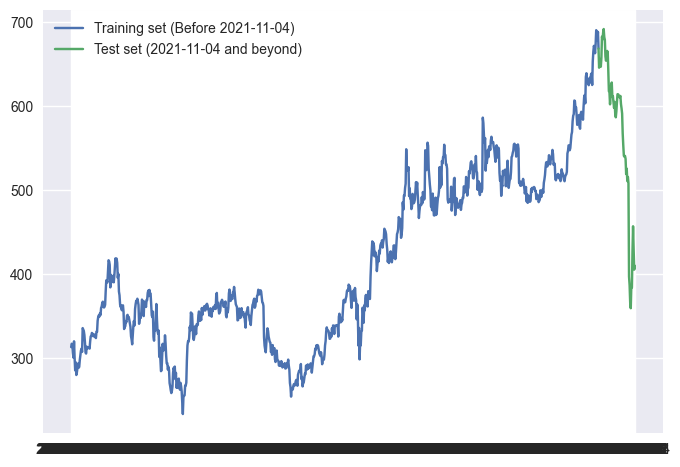

In [10]:
# df[target][train_start_date:train_end_date].plot(figsize=(16,4),legend=True)
# df[target][test_start_date:].plot(figsize=(16,4),legend=True)

plt.plot(df[target][train_start_date:train_end_date])
plt.plot(df[target][test_start_date:])
plt.legend([f'Training set (Before {train_end_date})',f'Test set ({test_start_date} and beyond)'])

plt.show()

In [11]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [12]:
timesteps = 8
# First, we create data sets where each sample has with 8 timesteps and 1 output
# So for each element of training set, we have 8 previous training set elements 
x_train = []
y_train = []
for i in range(timesteps,training_set.shape[0]):
    x_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train[0], y_train[0])
print(x_train[1], y_train[1])


[0.17439697 0.18320443 0.18096972 0.15954255 0.14692285 0.18944855
 0.14637512 0.11368662] 0.1346756390744024
[0.18320443 0.18096972 0.15954255 0.14692285 0.18944855 0.14637512
 0.11368662 0.13467564] 0.10168044324817183


In [13]:
print(x_train.shape, y_train.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(909, 8) (909,)
(909, 8, 1) (909,)


In [14]:
print(x_train.shape, y_train.shape)
# Interestingly - randomly arranging the samples works well, since we are using validation_split = 0.2, (rather then validation_data = )
# It is worth looking into whether using a K-fold would work better - if so would not use random permutation.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

(909, 8, 1) (909,)


In [15]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [16]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

In [17]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr


In [18]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [19]:
input_shape = x_train.shape[1:]
print(input_shape)

(8, 1)


In [20]:
model = build_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)



history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=20,
    callbacks=callbacks,
)

Epoch 1/100
37/37 [==============================] - 7s 81ms/step - loss: 0.0922 - mean_squared_error: 0.0922 - val_loss: 0.0862 - val_mean_squared_error: 0.0862 - lr: 1.0000e-06
Epoch 2/100
37/37 [==============================] - 3s 71ms/step - loss: 0.0617 - mean_squared_error: 0.0617 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - lr: 3.4300e-05
Epoch 3/100
37/37 [==============================] - 3s 72ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - lr: 6.7600e-05
Epoch 4/100
37/37 [==============================] - 3s 71ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - lr: 1.0090e-04
Epoch 5/100
37/37 [==============================] - 3s 70ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - lr: 1.3420e-04
Epoch 6/100
37/37 [==============================] - 3s 71ms/step - loss: 0.0108 - mean_squared_error: 0.

2/2 [==============================] - 0s 36ms/step
[429.480011] [405.600006] [410.170013]
[457.130005] [429.480011] [405.600006]
[416.769]


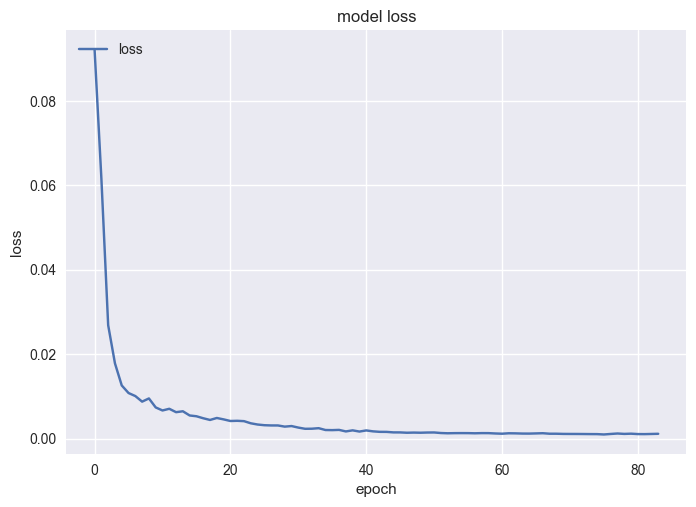

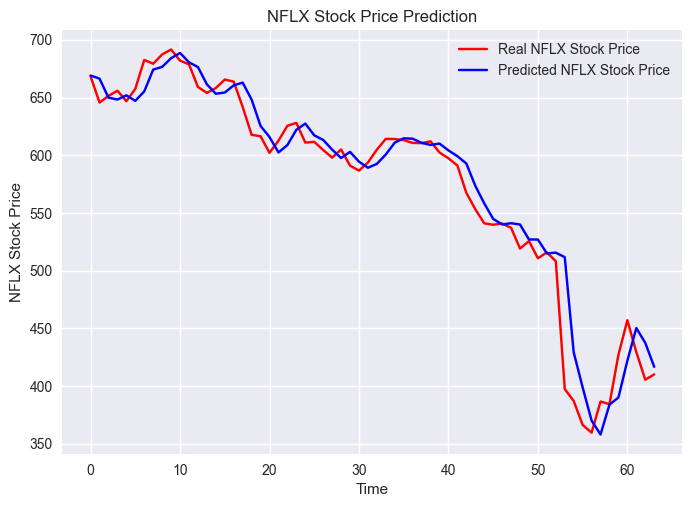

The root mean squared error is 21.09904089972443.


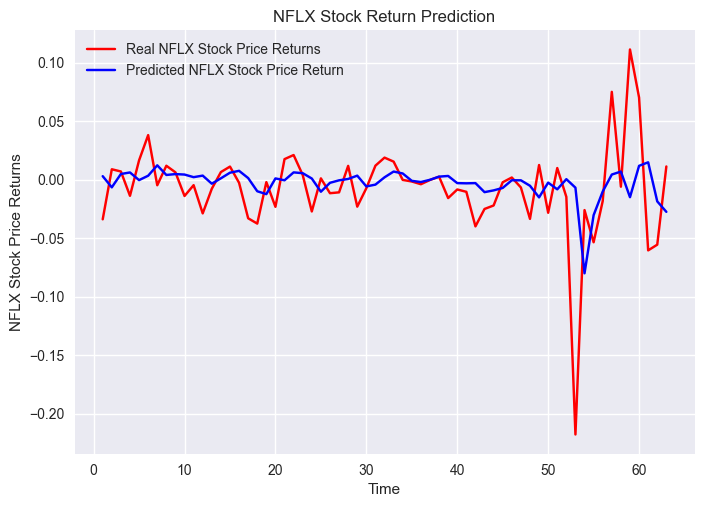

The root mean squared error is 0.03932540003799116.


0.03932540003799116

In [21]:
dataset_total = pd.concat((df[target][:train_end_date],df[target][test_start_date:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)

X_test = []
for i in range(timesteps,test_set.shape[0] + timesteps):
    X_test.append(inputs[i-timesteps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


print(test_set[-3],test_set[-2], test_set[-1])
shifted_test_set = shift(test_set, 1) #The shift function is defined early in the notebook
print(shifted_test_set[-3],shifted_test_set[-2], shifted_test_set[-1])

print(predicted_stock_price[-1])
prediction_error = test_set - predicted_stock_price # This is the error on the same day
#Before we can calculate the predicted return we have to shift the test_set to the day before so we use the shifted_test_set
predicted_return = (shifted_test_set - predicted_stock_price) / shifted_test_set

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

plot_predictions(test_set,predicted_stock_price,"NFLX")
return_rmse(test_set,predicted_stock_price)

plot_return_predictions(test_set_return,predicted_return,"NFLX")
return_rmse(test_set_return[1:], predicted_return[1:])

In [23]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 8, 1)        2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 8, 1)        19321       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              